<a href="https://colab.research.google.com/github/sammy-suyama/PythonBayesianMLBook/blob/main/chapter3/3_4_%E4%B8%80%E8%88%AC%E5%8C%96%E7%B7%9A%E5%BD%A2%E3%83%A2%E3%83%87%E3%83%AB_%E3%83%AD%E3%82%B8%E3%82%B9%E3%83%86%E3%82%A3%E3%83%83%E3%82%AF%E5%9B%9E%E5%B8%B0%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title install packages
!pip install watermark
#!pip install pymc3==3.11.4
!pip install pymc3

You should consider upgrading via the '/Users/sugiurahajime/programming/PythonBayesianMLBook/.venv/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/Users/sugiurahajime/programming/PythonBayesianMLBook/.venv/bin/python3.9 -m pip install --upgrade pip' command.


In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

sns.set_context('talk', font_scale=0.8)

In [15]:
# アイリスデータセットの読み込み
iris_dataset = sns.load_dataset('iris')

# サンプルデータ数
N = 50

# setosaとversicolorのみ抽出
iris_dataset_2species = iris_dataset[iris_dataset['species'].isin(['setosa', 'versicolor'])].copy()

# 使用するデータをサンプリング
iris_dataset_use = iris_dataset_2species.sample(N, random_state=1)
print(iris_dataset_use[['sepal_length', 'sepal_width']].copy().values)
# 説明変数
x_data = iris_dataset_use[['sepal_length', 'sepal_width']].copy().values
# バイアス項の追加
x_data_add_bias = np.concatenate([x_data, np.ones((N,1))],axis=1)

# 目的変数
y_data = pd.Categorical(iris_dataset_use['species']).codes

[[5.5 2.4]
 [5.4 3. ]
 [5.5 4.2]
 [5.5 2.4]
 [5.  2.3]
 [5.1 3.5]
 [5.5 3.5]
 [5.8 2.7]
 [5.6 2.5]
 [6.7 3.1]
 [5.8 2.6]
 [5.1 3.4]
 [6.3 3.3]
 [6.9 3.1]
 [6.4 3.2]
 [5.2 4.1]
 [5.4 3.4]
 [5.1 3.8]
 [6.  2.9]
 [5.4 3.7]
 [4.7 3.2]
 [6.1 2.8]
 [6.2 2.9]
 [6.  2.2]
 [5.1 3.8]
 [5.  3.2]
 [5.6 2.7]
 [5.2 3.5]
 [5.1 3.8]
 [4.4 3. ]
 [5.8 2.7]
 [5.7 2.8]
 [6.5 2.8]
 [5.7 3. ]
 [5.6 3. ]
 [5.  3.5]
 [5.3 3.7]
 [5.2 2.7]
 [5.1 3.3]
 [4.9 3.1]
 [6.7 3.1]
 [5.5 2.3]
 [6.7 3. ]
 [5.7 4.4]
 [6.  2.7]
 [4.5 2.3]
 [4.8 3. ]
 [6.1 3. ]
 [5.  3.4]
 [5.1 2.5]]


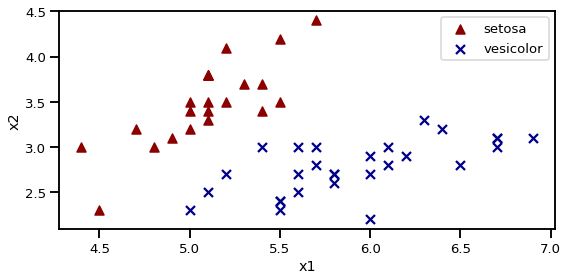

In [4]:
fig, ax = plt.subplots(figsize=(8, 4))

# データをspeciesで分割して可視化
x_data_set = x_data[y_data==0]
x_data_ves = x_data[y_data==1]

ax.scatter(x=x_data_set[:,0], y=x_data_set[:,1], color='darkred', marker='^',label='setosa')
ax.scatter(x=x_data_ves[:,0], y=x_data_ves[:,1], color='darkblue', marker='x', label='vesicolor')

ax.set_xlabel('x1')
ax.set_ylabel('x2');
ax.legend()
plt.tight_layout()

In [5]:
import pymc3 as pm

In [6]:
# モデルの定義
with pm.Model() as model:
    # 説明変数
    x = pm.Data("x", x_data_add_bias)
    # 推論対象のパラメータ事前分布
    w = pm.Normal('w', mu=0.0, sigma=1.0, shape=3)
    # 尤度関数
    y = pm.Bernoulli('y', logit_p =w.dot(x.T), observed=y_data)

In [7]:
with model:
    # MCMCによる推論
    trace = pm.sample(draws=3000, tune=1000, chains=3, random_seed=1, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [w]


Sampling 3 chains for 1_000 tune and 3_000 draw iterations (3_000 + 9_000 draws total) took 61 seconds.


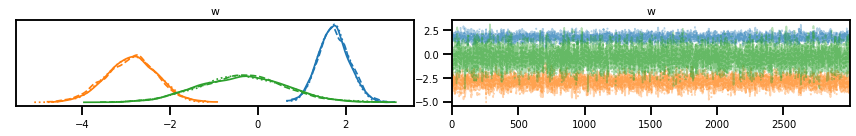

In [8]:
az.plot_trace(trace);
plt.tight_layout()

In [9]:
for var_info in az.rhat(trace).values():
  print(var_info.name, var_info.values.round(3), sep=' ')

w [1.001 1.001 1.   ]


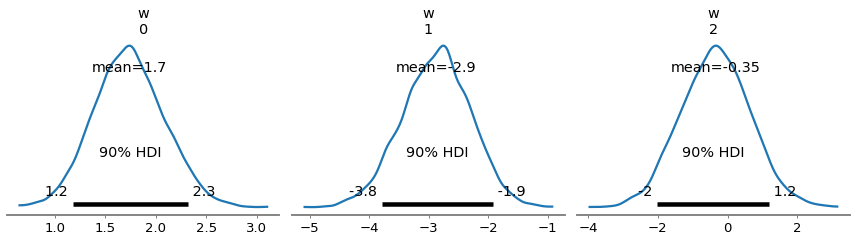

In [10]:
az.plot_posterior(trace, hdi_prob=0.9, figsize=(12,3.5));
plt.tight_layout()

(2.0, 4.5)

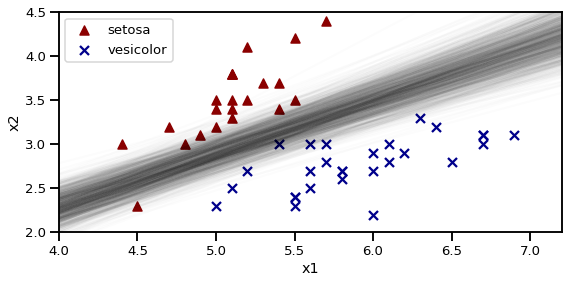

In [25]:
# サンプルの取り出し(チェーン3つ分を結合)
w_mcmc_samples = trace.posterior['w'].values.reshape(9000,3)

#　各次元ごとに取り出し
w1_samples = w_mcmc_samples[:,0]
w2_samples = w_mcmc_samples[:,1]
w3_samples = w_mcmc_samples[:,2]

fig, ax = plt.subplots(figsize=(8, 4))
# サンプルデータ
ax.scatter(x=x_data_set[:,0], y=x_data_set[:,1], color='darkred', marker='^',label='setosa')
ax.scatter(x=x_data_ves[:,0], y=x_data_ves[:,1], color='darkblue', marker='x', label='vesicolor')

N_new = 10
x1 = np.linspace(4.0, 7.2, N_new)
for i in range(0, 9000, 10):
  # x1に対してθ=0.5となるx2
  x2 = - w3_samples[i]/w2_samples[i]-w1_samples[i]/w2_samples[i]*x1
  ax.plot(x1, x2, alpha=0.01, color='black')
ax.set_xlabel('x1')
ax.set_ylabel('x2');
ax.legend()
plt.tight_layout()
ax.set_xlim(4.0, 7.2);ax.set_ylim(2.0, 4.5)

In [12]:
# 2次元のグリッド状データ作成（100×100）
N_new = 100
x1_linspace = np.linspace(4.0, 7.2, N_new)
x2_linspace = np.linspace(2.0, 4.5, N_new)
x1_grid, x2_grid = np.meshgrid(x1_linspace, x2_linspace)
x_new = np.array([[x1, x2]  for x1, x2 in zip(x1_grid.ravel(), x2_grid.ravel())])
x_new_add_bias = np.concatenate([x_new, np.ones((N_new**2, 1))], axis=1)

with model:
  # 検証用データをモデルに入力
  pm.set_data({"x": x_new_add_bias})
  # 予測分布からサンプリング
  pred = pm.sample_posterior_predictive(trace, samples=3000, random_seed=1)

y_pred_samples = pred['y']

/Users/sugiurahajime/programming/PythonBayesianMLBook/.venv/lib/python3.9/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


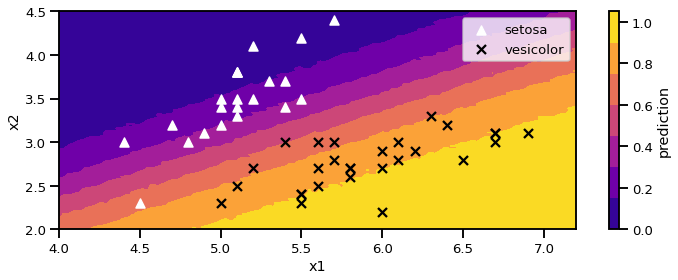

In [13]:
fig, ax = plt.subplots(figsize=(10, 4))
# 等高線図
contourf = ax.contourf(x1_grid, x2_grid, y_pred_samples.mean(axis=0).reshape(N_new,N_new), cmap="plasma")
#　サンプルデータ
ax.scatter(x=x_data_set[:,0], y=x_data_set[:,1], color='white', marker='^',label='setosa')
ax.scatter(x=x_data_ves[:,0], y=x_data_ves[:,1], color='black', marker='x', label='vesicolor')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.legend()
cbar = fig.colorbar(contourf, ax=ax)
cbar.set_label('prediction')
cbar.set_ticks(ticks=np.arange(0,1.1,0.2))
plt.tight_layout();

In [14]:
%load_ext watermark
%watermark --iversions

seaborn   : 0.11.2
scipy     : 1.7.3
numpy     : 1.22.1
matplotlib: 3.5.2
arviz     : 0.12.1
pymc3     : 3.11.5
sys       : 3.9.12 (main, Mar 26 2022, 15:51:15) 
[Clang 13.1.6 (clang-1316.0.21.2)]
pandas    : 1.4.2

